In [1]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Install dan Import Library :

In [2]:
!pip install optuna


In [3]:
!pip install gensim

In [4]:
import optuna
import pandas as pd
import numpy as np
import gensim
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, Bidirectional, GRU, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report


# Load Dataset :

In [5]:
file_path = "/content/drive/MyDrive/DistilBERT-7-Mei/combined_dataset.csv"
df = pd.read_csv(file_path)

In [6]:
df.head()

,Unnamed: 0,Label,clean_text,String,encoded_label
0,0,Non-bullying,kaka tidur yaa sudah pagi tidak boleh capek2,"""Kaka tidur yaa, udah pagi, gaboleh capek2""",1.0
1,1,Non-bullying,makan nasi padang saja badannya,"""makan nasi padang aja begini badannya""",1.0
2,2,Bullying,suka cukur jembut manggung,"""yang aku suka dari dia adalah selalu cukur je...",0.0
3,3,Non-bullying,hai kak isyana ngefans sekali kak isyana suka ...,"""Hai kak Isyana aku ngefans banget sama kak Is...",1.0
4,4,Non-bullying,manusia bidadari sih herann deh cantik,"""Manusia apa bidadari sih herann deh cantik te...",1.0


# Train-Test Split :

In [7]:
X = df['clean_text'].astype(str)
y = df['encoded_label']

# LabelEncoder untuk nama kelas
le = LabelEncoder()
le.fit(df['Label'])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Tokenisasi dan Padding :

In [8]:
max_words = 20000
max_len = 50

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

X_train_pad = pad_sequences(X_train_seq, maxlen=max_len)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len)


# Download dan Extract file pre-trained embedding FastText :

In [9]:
!wget -c https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.id.300.vec.gz
!gunzip cc.id.300.vec.gz


--2025-09-19 06:53:49--  https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.id.300.vec.gz
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 18.239.69.63, 18.239.69.122, 18.239.69.104, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|18.239.69.63|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1227018698 (1.1G) [binary/octet-stream]
Saving to: ‘cc.id.300.vec.gz’

cc.id.300.vec.gz    100%[===================>]   1.14G  5.81MB/s    in 9.9s    

2025-09-19 06:53:59 (118 MB/s) - ‘cc.id.300.vec.gz’ saved [1227018698/1227018698]



# Import Pre-Trained embedding fastext ke framework Gensim :

In [10]:
from gensim.models import KeyedVectors

fasttext_model = KeyedVectors.load_word2vec_format('cc.id.300.vec', binary=False)
embedding_dim = 300  # ukuran embedding dari fastText


# Membuat Embedding Matrix :

In [11]:
word_index = tokenizer.word_index
num_words = min(max_words, len(word_index) + 1)

embedding_matrix = np.zeros((num_words, embedding_dim))
for word, i in word_index.items():
    if i >= max_words:
        continue
    if word in fasttext_model:
        embedding_matrix[i] = fasttext_model[word]

# Optuna Model Function :

In [12]:
def create_model(trial):
    model = Sequential()
    model.add(Embedding(
        input_dim=num_words,
        output_dim=embedding_dim,
        weights=[embedding_matrix],
        input_length=max_len,
        trainable=False
    ))

    # Hyperparameter tuning: GRU units
    gru_units = trial.suggest_categorical("gru_units", [64, 128, 256])
    model.add(Bidirectional(GRU(gru_units, return_sequences=False)))

    # Hyperparameter tuning: Dropout
    dropout_rate = trial.suggest_float("dropout", 0.3, 0.6, step=0.1)
    model.add(Dropout(dropout_rate))

    # Hyperparameter tuning: Dense layer
    dense_units = trial.suggest_categorical("dense_units", [32, 64, 128])
    model.add(Dense(dense_units, activation='relu'))

    model.add(Dense(1, activation='sigmoid'))

    # Hyperparameter tuning: Learning rate
    learning_rate = trial.suggest_categorical("learning_rate", [1e-2, 1e-3, 1e-4])
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model


# Optuna Objective Function :

In [13]:
def objective(trial):
    model = create_model(trial)

    batch_size = trial.suggest_categorical("batch_size", [32, 64, 128])

    callbacks = [
        EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6)
    ]

    history = model.fit(
        X_train_pad, y_train,
        validation_split=0.2,
        epochs=20,
        batch_size=batch_size,
        callbacks=callbacks,
        verbose=0
    )

    val_acc = max(history.history['val_accuracy'])
    return val_acc


# Jalankan Hyperparameter Tuning :

In [14]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=10)  # coba 10x, bisa dinaikkan

print("Best trial:", study.best_trial.params)


[I 2025-09-19 07:01:33,197] A new study created in memory with name: no-name-deaa8d88-992a-4d76-a3eb-96f6f8f6deaa
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
[I 2025-09-19 07:01:45,951] Trial 0 finished with value: 0.8338368535041809 and parameters: {'gru_units': 128, 'dropout': 0.3, 'dense_units': 32, 'learning_rate': 0.01, 'batch_size': 128}. Best is trial 0 with value: 0.8338368535041809.
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
[I 2025-09-19 07:01:51,384] Trial 1 finished with value: 0.8670694828033447 and parameters: {'gru_units': 64, 'dropout': 0.4, 'dense_units': 64, 'learning_rate': 0.001, 'batch_size': 128}. Best is trial 1 with value: 0.8670694828033447.
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserW

Best trial: {'gru_units': 64, 'dropout': 0.4, 'dense_units': 64, 'learning_rate': 0.001, 'batch_size': 128}


# Train Model dengan Best Params :

In [15]:
best_params = study.best_trial.params
print("Training dengan best params:", best_params)

final_model = create_model(study.best_trial)

callbacks = [
    EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6)
]

final_model.fit(
    X_train_pad, y_train,
    validation_split=0.2,
    epochs=20,
    batch_size=best_params["batch_size"],
    callbacks=callbacks,
    verbose=1
)


Training dengan best params: {'gru_units': 64, 'dropout': 0.4, 'dense_units': 64, 'learning_rate': 0.001, 'batch_size': 128}
Epoch 1/20


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - accuracy: 0.5235 - loss: 0.6876 - val_accuracy: 0.5529 - val_loss: 0.6699 - learning_rate: 0.0010
Epoch 2/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.5424 - loss: 0.6646 - val_accuracy: 0.5891 - val_loss: 0.6356 - learning_rate: 0.0010
Epoch 3/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.6700 - loss: 0.6118 - val_accuracy: 0.7855 - val_loss: 0.5617 - learning_rate: 0.0010
Epoch 4/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.7917 - loss: 0.5205 - val_accuracy: 0.7946 - val_loss: 0.4334 - learning_rate: 0.0010
Epoch 5/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.8170 - loss: 0.4120 - val_accuracy: 0.7976 - val_loss: 0.4231 - learning_rate: 0.0010
Epoch 6/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.8321 - loss: 0.3732 - val_accuracy: 0.8036 - val_loss: 0.4084 - learning_rate: 0.0010
Epoch 7/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.8567 - loss: 0.3259 - val_accuracy: 0.82

# Evaluasi hasil train model Bi-GRU + Optuna :

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step
              precision    recall  f1-score   support

    Bullying       0.88      0.83      0.85       219
Non-bullying       0.82      0.87      0.84       195

    accuracy                           0.85       414
   macro avg       0.85      0.85      0.85       414
weighted avg       0.85      0.85      0.85       414



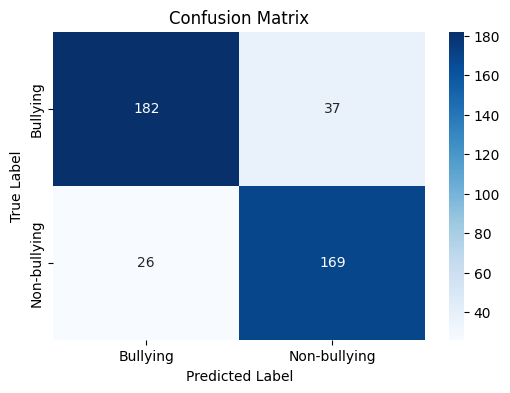

In [16]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Prediksi
y_pred = (final_model.predict(X_test_pad) > 0.5).astype("int32")

# Classification Report
class_names = le.inverse_transform([0, 1])
print(classification_report(y_test, y_pred, target_names=class_names))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


# Clear session (biar model lama tidak ganggu):

In [17]:
import tensorflow as tf
tf.keras.backend.clear_session()


In [18]:
# Definisikan ulang model (gunakan baseline atau versi Optuna, tapi jangan pakai EarlyStopping di callbacks):

In [19]:
best_params = study.best_params
print(best_params)


{'gru_units': 64, 'dropout': 0.4, 'dense_units': 64, 'learning_rate': 0.001, 'batch_size': 128}


In [20]:
tf.keras.backend.clear_session()

model = Sequential()
model.add(Embedding(
    input_dim=num_words,
    output_dim=embedding_dim,
    weights=[embedding_matrix],
    input_length=max_len,
    trainable=False
))
model.add(Bidirectional(GRU(best_params["gru_units"], return_sequences=False)))
model.add(Dropout(best_params["dropout"]))
model.add(Dense(best_params["dense_units"], activation='relu'))
model.add(Dense(1, activation='sigmoid'))

optimizer = tf.keras.optimizers.Adam(learning_rate=best_params["learning_rate"])
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


# Train-Ulang tanpa Early Stopping :

In [21]:
history = model.fit(
    X_train_pad, y_train,
    validation_split=0.2,
    epochs=20,       # full epoch tanpa berhenti
    batch_size=32,
    verbose=1
)


Epoch 1/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.5651 - loss: 0.6781 - val_accuracy: 0.6526 - val_loss: 0.6085
Epoch 2/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7485 - loss: 0.5410 - val_accuracy: 0.7976 - val_loss: 0.4635
Epoch 3/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.8320 - loss: 0.3844 - val_accuracy: 0.8248 - val_loss: 0.4766
Epoch 4/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8306 - loss: 0.3737 - val_accuracy: 0.8520 - val_loss: 0.3533
Epoch 5/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8969 - loss: 0.2846 - val_accuracy: 0.8671 - val_loss: 0.3422
Epoch 6/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8787 - loss: 0.2775 - val_accuracy: 0.8610 - val_loss: 0.3867
Epoch 7/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9204 - loss: 0.2284 - val_accuracy: 0.8459 - val_loss: 0.3791
Epoch 8/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9337 - loss: 0.1965 - val_accuracy: 0.8459 - v

# Evaluasi performa (classification report + confusion matrix):

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
              precision    recall  f1-score   support

    Bullying       0.86      0.89      0.87       219
Non-bullying       0.87      0.84      0.85       195

    accuracy                           0.86       414
   macro avg       0.87      0.86      0.86       414
weighted avg       0.86      0.86      0.86       414



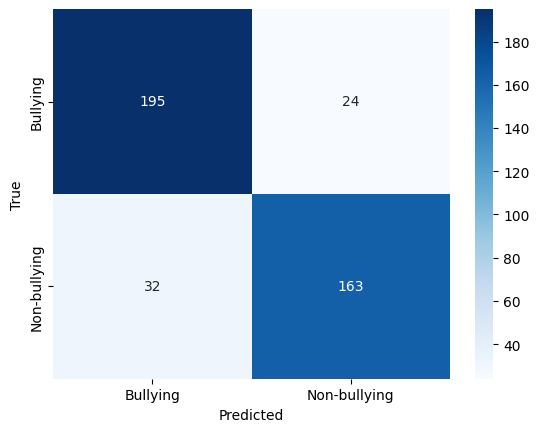

In [22]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

y_pred = (model.predict(X_test_pad) > 0.5).astype("int32")

# Provide the correct target names for the binary classification
class_names = ['Bullying', 'Non-bullying']
print(classification_report(y_test, y_pred, target_names=class_names))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# Split Data Train-Test dengan Stratifikasi

In [23]:
from sklearn.model_selection import train_test_split

X = df['clean_text'].astype(str)
y = df['encoded_label']  # tetap sama


In [24]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y   # ini memastikan proporsi label tetap sama
)

print("Jumlah data train:", len(X_train))
print("Jumlah data test:", len(X_test))

Jumlah data train: 1652
Jumlah data test: 414


# Tokenisasi & Padding

In [26]:
max_words = 20000
max_len = 50
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

X_train_pad = pad_sequences(X_train_seq, maxlen=max_len)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len)

print("X_train_pad shape:", X_train_pad.shape)
print("X_test_pad shape:", X_test_pad.shape)

X_train_pad shape: (1652, 50)
X_test_pad shape: (414, 50)


# Bangun Model Bi-GRU untuk dataset Terstratifikasi :

In [28]:
tf.keras.backend.clear_session()

model = Sequential()
model.add(Embedding(
    input_dim=num_words,
    output_dim=embedding_dim,
    weights=[embedding_matrix],
    input_length=max_len,
    trainable=False
))
model.add(Bidirectional(GRU(best_params["gru_units"], return_sequences=False)))
model.add(Dropout(best_params["dropout"]))
model.add(Dense(best_params["dense_units"], activation='relu'))
model.add(Dense(1, activation='sigmoid'))

optimizer = tf.keras.optimizers.Adam(learning_rate=best_params["learning_rate"])
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])


In [29]:
history = model.fit(
    X_train_pad, y_train,
    validation_split=0.2,
    epochs=20,       # full epoch tanpa berhenti
    batch_size=32,
    verbose=1
)


Epoch 1/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - accuracy: 0.5227 - loss: 0.6891 - val_accuracy: 0.5045 - val_loss: 0.6791
Epoch 2/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5908 - loss: 0.6552 - val_accuracy: 0.6858 - val_loss: 0.6036
Epoch 3/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.7206 - loss: 0.5599 - val_accuracy: 0.7069 - val_loss: 0.5545
Epoch 4/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7785 - loss: 0.4908 - val_accuracy: 0.7341 - val_loss: 0.5346
Epoch 5/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.8234 - loss: 0.4290 - val_accuracy: 0.7341 - val_loss: 0.5453
Epoch 6/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8195 - loss: 0.4263 - val_accuracy: 0.7523 - val_loss: 0.5423
Epoch 7/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.8225 - loss: 0.4065 - val_accuracy: 0.7492 - val_loss: 0.5220
Epoch 8/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8592 - loss: 0.3656 - val_accuracy: 0.7613 - v

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step
              precision    recall  f1-score   support

    Bullying       0.77      0.81      0.79       228
Non-bullying       0.75      0.70      0.72       186

    accuracy                           0.76       414
   macro avg       0.76      0.76      0.76       414
weighted avg       0.76      0.76      0.76       414



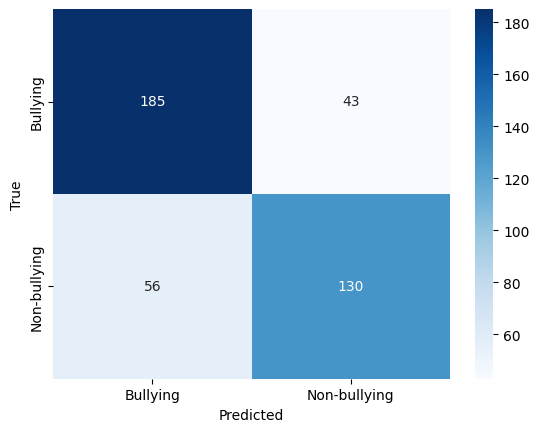

In [30]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

y_pred = (model.predict(X_test_pad) > 0.5).astype("int32")

# Provide the correct target names for the binary classification
class_names = ['Bullying', 'Non-bullying']
print(classification_report(y_test, y_pred, target_names=class_names))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

In [31]:
import tensorflow as tf

device_name = tf.test.gpu_device_name()
if device_name:
    print("GPU aktif:", device_name)
else:
    print("GPU tidak ditemukan")


GPU aktif: /device:GPU:0


In [32]:
!git clone https://github.com/WilliamAxelC/Indonesian-Cyberbullying-Detection-with-Distilbert.git


Cloning into 'Indonesian-Cyberbullying-Detection-with-Distilbert'...
remote: Enumerating objects: 83, done.
remote: Counting objects: 100% (83/83), done.
remote: Compressing objects: 100% (54/54), done.
remote: Total 83 (delta 39), reused 72 (delta 28), pack-reused 0 (from 0)
Receiving objects: 100% (83/83), 11.17 MiB | 10.21 MiB/s, done.
Resolving deltas: 100% (39/39), done.


In [33]:
import shutil, os

# Nama file notebook sesuai dengan yang kamu save di Drive
notebook_name = "Bi-GRU-Optuna-(EarlyStopping and No + Stratifikasi DATASET).ipynb"
src_path = f"/content/drive/MyDrive/Colab Notebooks/{notebook_name}"
repo_dir = "/content/Indonesian-Cyberbullying-Detection-with-Distilbert"

if os.path.exists(src_path):
    shutil.copy(src_path, f"{repo_dir}/{notebook_name}")
    print(f"✅ Copied {notebook_name} ke repo folder.")
else:
    print(f"⚠️ Notebook tidak ditemukan di {src_path}. Periksa nama file!")


⚠️ Notebook tidak ditemukan di /content/drive/MyDrive/Colab Notebooks/Bi-GRU-Optuna-(EarlyStopping and No + Stratifikasi DATASET).ipynb. Periksa nama file!
